In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [4]:
# CSVファイルのパス
csv_path = "../output/evaluation_metrics_pd_2025_0802_v1.0.csv"

# DataFrameに読み込む
df = pd.read_csv(csv_path)

# 確認
df.head()

,sample_ID,minADE_k,minFDE_k,MR_k,b-minFDE_k
0,10011,1.165350,0.956953,0.0,1.634606
1,10014,0.895588,0.879625,0.0,1.502939
2,10015,0.889754,1.101292,0.0,1.729987
3,10036,0.679105,2.225650,1.0,3.224746
4,10051,0.424523,0.485293,0.0,1.242187


# 1️⃣ 各指標の分布（ヒストグラム + KDE）
- 各指標がどの範囲に集中しているかを把握
- 外れ値や閾値候補を視覚的に確認

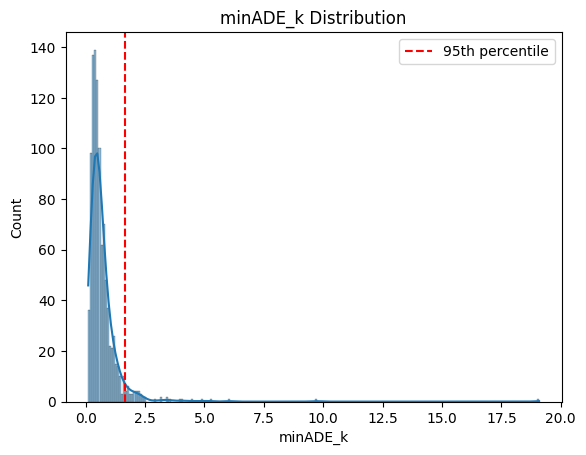

minADE_k の95パーセンタイル: 1.64693


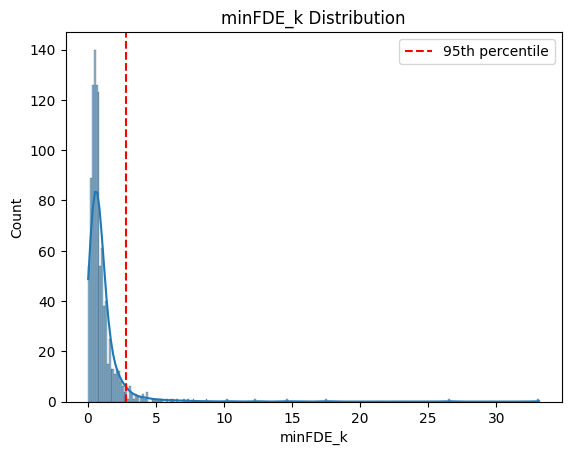

minFDE_k の95パーセンタイル: 2.79248


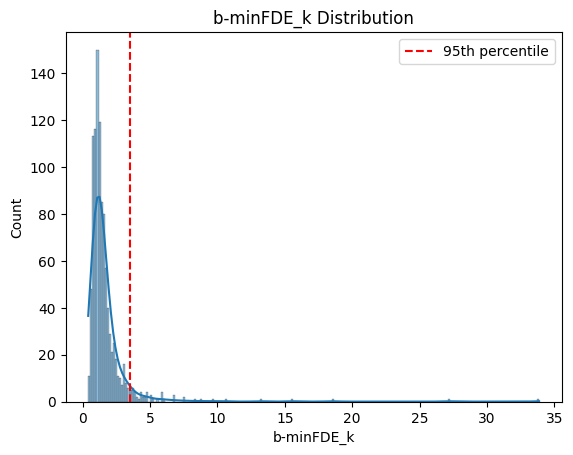

b-minFDE_k の95パーセンタイル: 3.49576


In [13]:
metrics = ['minADE_k', 'minFDE_k', 'b-minFDE_k']
for metric in metrics:
    sns.histplot(df[metric], kde=True)
    plt.axvline(df[metric].quantile(0.95), color='red', linestyle='--', label='95th percentile')
    plt.title(f'{metric} Distribution')
    plt.legend()
    plt.show()
    value_95 = df[metric].quantile(0.95)
    print(f"{metric} の95パーセンタイル: {value_95:.5f}")

# 2️⃣ minFDEの累積分布（CDF）
- MRの定義（2m以上）を反映しやすい
- 全サンプル中、2m以上の割合を可視化
- MR_k と minFDE_k の関係を確認

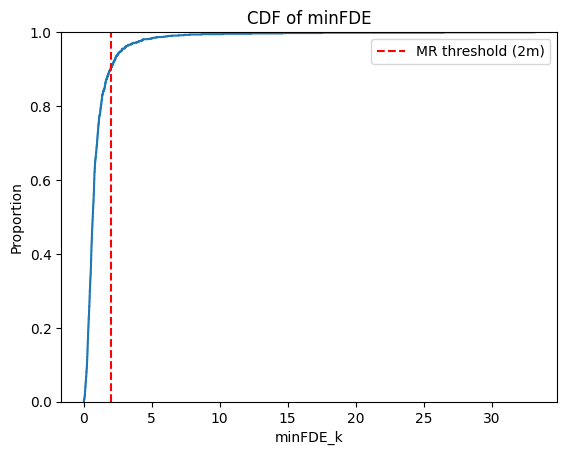

In [7]:
sns.ecdfplot(df['minFDE_k'])
plt.axvline(2.0, color='red', linestyle='--', label='MR threshold (2m)')
plt.title('CDF of minFDE')
plt.legend()
plt.show()

In [8]:
threshold = 2.0

# minFDE_k の 2m 以下の割合を計算
cdf_value = (df['minFDE_k'] <= threshold).mean()

print(f"minFDE_k = 2.0m の累積確率 (縦軸の交差点): {cdf_value:.4f}")

minFDE_k = 2.0m の累積確率 (縦軸の交差点): 0.9014


In [9]:
thresholds = [1.0, 2.0, 3.0]
cdf_values = {t: (df['minFDE_k'] <= t).mean() for t in thresholds}

print(cdf_values)

{1.0: 0.703125, 2.0: 0.9013671875, 3.0: 0.955078125}


# 3️⃣ 指標間の関係（散布図 / ペアプロット）
- minADE, minFDE, b-minFDE の相関関係を可視化
- 例えば minFDE が悪いシナリオは b-minFDE も大きいか確認

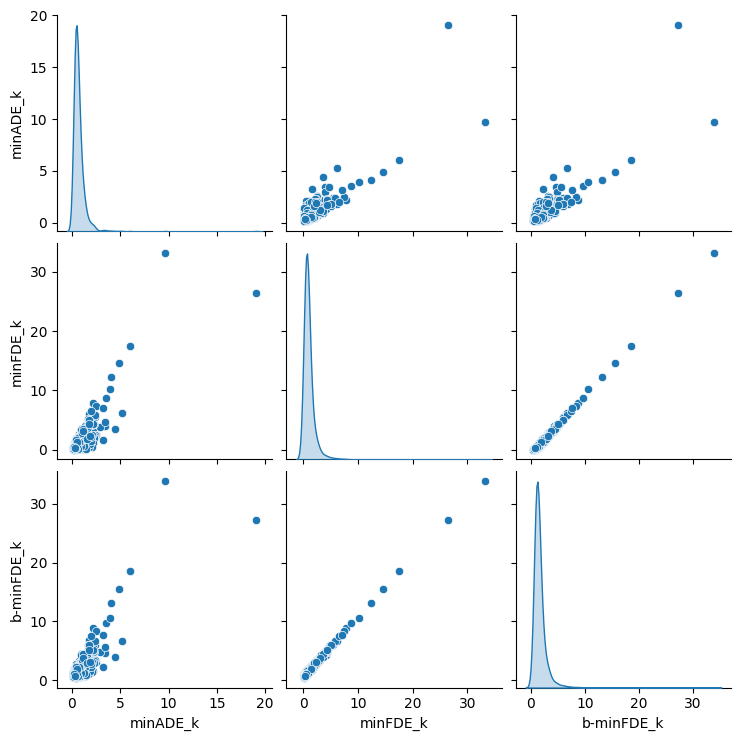

In [10]:
sns.pairplot(df[['minADE_k', 'minFDE_k', 'b-minFDE_k']], diag_kind='kde')
plt.show()

# 4️⃣ 良い/悪いシナリオのラベル分け
- 仮の閾値（例：minFDE > 2.0m or b-minFDE > 2.0）で良/悪を色分け
- 可視的にクラスタが分かれるか確認

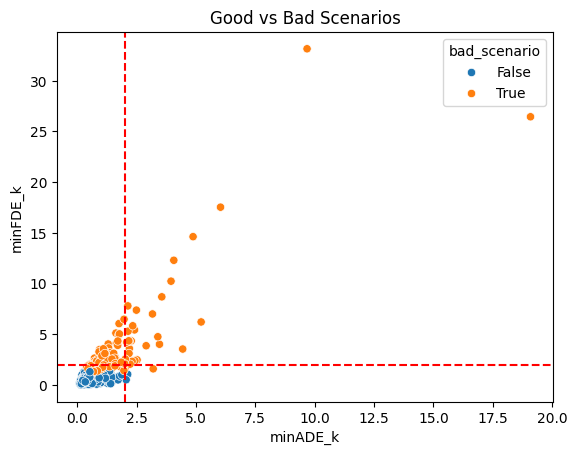

In [11]:
df['bad_scenario'] = (df['minFDE_k'] > 2.0) | (df['b-minFDE_k'] > 2.0)
sns.scatterplot(data=df, x='minADE_k', y='minFDE_k', hue='bad_scenario')
plt.axvline(2.0, color='red', linestyle='--')
plt.axhline(2.0, color='red', linestyle='--')
plt.title('Good vs Bad Scenarios')
plt.show()


# 5️⃣ MRの全体割合とシーン別ヒートマップ
- MR_k を全体の miss 率としてバー表示
- sample_ID を横軸にして MR のヒートマップ化で、missが発生しやすいサンプルを可視化

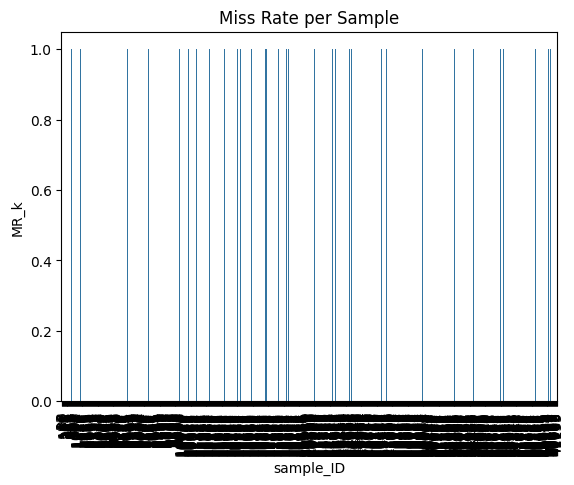

In [12]:
sns.barplot(x='sample_ID', y='MR_k', data=df)
plt.xticks(rotation=90)
plt.title('Miss Rate per Sample')
plt.show()


# ✅ 期待できる効果
1. ヒストグラム：指標の典型値と外れ値を把握 → 上位5%を悪いシナリオに設定

2. CDF：2m閾値の合理性を確認

3. 散布図：複数指標で悪いシナリオが集まる領域を発見

4. 良/悪色分け：識別器のラベル候補を視覚的に把握